🔍 DEBUG suggest_all_params - Parámetros generados:
🔍   CatBoost params: ['cat_main_iterations', 'cat_main_depth', 'cat_main_learning_rate', 'cat_main_l2_leaf_reg', 'cat_main_early_stopping', 'cat_meta_iterations', 'cat_meta_depth', 'cat_meta_learning_rate', 'cat_meta_l2_leaf_reg', 'cat_meta_early_stopping']
🔍   Feature params: ['feature_main_periods', 'feature_main_stats', 'feature_meta_periods', 'feature_meta_stats']
🔍   Label params: ['label_rolling', 'label_quantiles', 'label_polyorder', 'label_decay_factor', 'label_method_trend', 'label_method_random', 'label_markup', 'label_min_val', 'label_max_val', 'label_atr_period']
🔍   Algo params: ['lgmm_components', 'lgmm_covariance', 'lgmm_iter', 'mapie_confidence_level', 'mapie_cv', 'mapie_threshold_width', 'meta_threshold', 'model_main_percentile', 'oof_resid_percentile']
🔍   Total params: 33
🔍 DEBUG search_clusters lgmm - Parámetros clusters: {}
🔍 DEBUG: base_df.shape = (32877, 5)
🔍 DEBUG: train_start = 2020-02-01 00:00:00, train_end = 

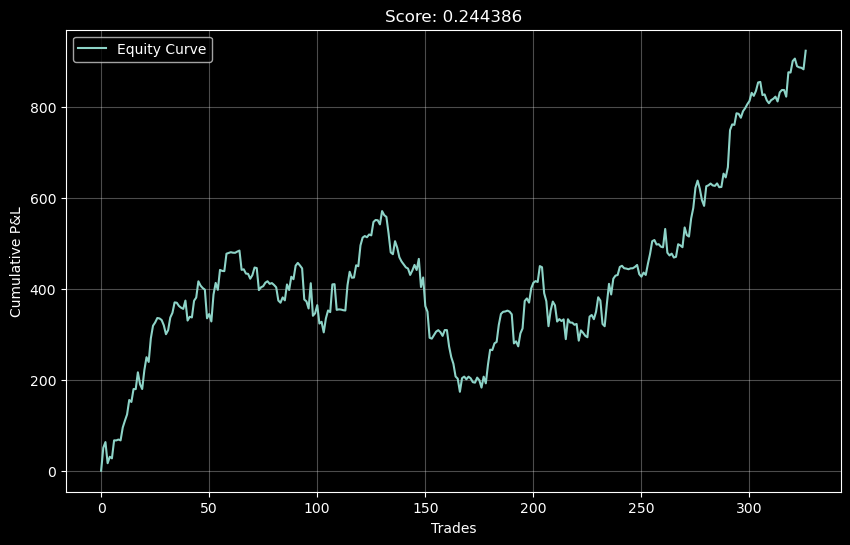

🔍 DEBUG: Tiempo de test in-sample: 0.36 segundos
🔍 DEBUG: Score in-sample: 0.244385709781267
🔍   DEBUG: Dataset con shape (29580, 41) guardado en /tmp/tmpehzto_x2.csv
🔍      labels_main resumen: min=3.697561, max=5.048568, mean=4.201382, std=0.249150
🔍      labels_meta resumen: min=0.000050, max=0.921791, mean=0.192318, std=0.289061
🔍 DEBUG: Modelos guardados en /tmp/tmp3im0_9si.onnx y /tmp/tmpf457zp9t.onnx
🔍   Nuevo mejor cluster 1.0: score = 0.244385709781267
🔍   Cluster 2.0 descartado: sin muestras confiables
🔍   Cluster 3.0 descartado: sin muestras confiables
🔍   Cluster 4.0 descartado: sin muestras confiables
🔍   Cluster 5.0 descartado: sin muestras confiables
🔍   Cluster 6.0 descartado: sin muestras confiables
[XAUUSD_H1_buy_cl_lg_ma_fi_re] modelo 0 trial 2/5000 score=0.244386 avg=9.42s mem=461.04MB 
🔍 DEBUG: Study terminado después de 2 trials
🔍   n_trials configurado: 5000
🔍   best_trial: FrozenTrial(number=1, state=1, values=[0.244385709781267], datetime_start=datetime.datetim

In [1]:
import optuna
from datetime import datetime
from concurrent.futures import ProcessPoolExecutor, as_completed
from modules.StrategySearcher import StrategySearcher
import warnings
import os
warnings.filterwarnings("ignore")

configs = [
    dict(
        symbol='XAUUSD', timeframe='H1', direction='buy', pruner_type='hyperband',
        train_start=datetime(2020,2,1), train_end=datetime(2025,2,1),
        test_start=datetime(2022,2,1),  test_end=datetime(2023,2,1),
        search_type='clusters', search_subtype='lgmm', search_filter='mapie',
        label_method='filter', label_type='regression', n_models=1, debug=True,
    ),
    # dict(
    #     symbol='XAUUSD', timeframe='H1', direction='buy', pruner_type='hyperband',
    #     train_start=datetime(2020,2,1), train_end=datetime(2025,2,1),
    #     test_start=datetime(2022,2,1),  test_end=datetime(2023,2,1),
    #     search_type='clusters', search_subtype='lgmm', search_filter='causal',
    #     label_method='filter', label_type='classification', n_models=1, debug=False,
    # ),
    
]

# Crear tag para cada configuración
for cfg in configs:
    cfg["tag"] = f"{cfg['symbol']}_{cfg['timeframe']}_{cfg['direction']}_{cfg['search_type'][:2]}_{cfg.get('search_subtype', '')[:2]}_{cfg.get('search_filter', '')[:2]}_{cfg['label_method'][:2]}_{cfg['label_type'][:2]}".replace("__", "_").strip("_")

DB_FILE = f"optuna_dbs/{cfg['tag']}.db"
DB_PATH = f"sqlite:///{DB_FILE}"
STUDY_NAME = f"{cfg['tag']}"

study = None
if not os.path.exists(DB_FILE):
    study = None
else:
    try:
        study = optuna.load_study(study_name=STUDY_NAME, storage=DB_PATH)
    except Exception:
        study = None

n_trials = 5000
if study:
    n_trials = len(study.trials) + n_trials

for cfg in configs:
    cfg['n_trials'] = n_trials

def launch(cfg):
    s = StrategySearcher(**cfg)
    s.run_search()

with ProcessPoolExecutor(max_workers=len(configs)) as pool:
    futures = {pool.submit(launch, c): c["tag"] for c in configs}
    for f in as_completed(futures):
        tag = futures[f]
        try:
            print(f"[{tag}] terminado")
        except Exception as e:
            print(f"[{tag}] falló: {e}")